In [0]:
import re

from pyspark.sql import Row

# This is the regular expression specific to Apache log analysis, which can be changed to different log formats as needed
# Example of an Apache log line:
#                              127.0.0.1 - - [21/Jul/2014:9:55:27 -0800] "GET /home.html HTTP/1.1" 200 2048
#                              1:IP  2:client 3:user 4:date time           5:method 6:req 7:proto   8:respcode 9:size
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+) (\S+)" (\d{3}) (\d+)'

# The function below is modeled specifically to the Apache Access Logs model, which can be modified as needed for different log formats
# Return a dictionary containing the Apache access log parts.
def parse_apache_log_line(logline):
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        raise Error("Invalid logline: %s" % logline)
    return Row(
        ip_address    = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date = (match.group(4)[:-6]).split(":", 1)[0],
        time = (match.group(4)[:-6]).split(":", 1)[1],
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = int(match.group(9))
    )

In [0]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
import sys


#input file
logFile = '/FileStore/tables/apache_access.log'

# .cache() - Keeps the RDD in memory, which will be reused
access_logs = (sc.textFile(logFile)
               .map(parse_apache_log_line)
               .cache())
access_logs.count()

Out[5]: 1406

In [0]:
schema_access_logs = sqlContext.createDataFrame(access_logs)
#Create a table on which SQL type queries can be triggered for analysis
#schema_access_logs.registerTempTable("logs")
schema_access_logs.createOrReplaceTempView("logs")

In [0]:
# traffic size per address (page or endpoint)
topEndpointsMaxSize = (sqlContext
                .sql("SELECT endpoint,content_size/1024 FROM logs ORDER BY content_size DESC LIMIT 10")
                .rdd.map(lambda row: (row[0], row[1]))
                .collect())

In [0]:
display(topEndpointsMaxSize)

_1,_2
/twiki/bin/rdiff/TWiki/TWikiHistory,135.5361328125
/twiki/bin/rdiff/Main/WebChanges,111.5634765625
/twiki/bin/rdiff/Main/WebChanges?rev1=1.2&rev2=1.1,111.54296875
/twiki/bin/rdiff/TWiki/WebChanges,111.4912109375
/twiki/bin/rdiff/TWiki/WebHome,105.626953125
/twiki/bin/search/TWiki/?scope=topic®ex=on&bookview=on&search=.*,99.9990234375
/twiki/bin/view/TWiki/WebIndex,99.759765625
/twiki/bin/rdiff/TWiki/TWikiTopics,99.0673828125
/twiki/bin/search/TWiki/?search=\\.*&scope=topic&order=modified&reverse=on®ex=on&nosearch=on&limit=200,98.9052734375
/twiki/bin/rdiff/TWiki/TWikiSite,70.2548828125


In [0]:
# Display the number of times a response code has been triggered
responseCodeToCount = (sqlContext
                       .sql("SELECT response_code, COUNT(*) AS theCount FROM logs GROUP BY response_code")
                       .rdd.map(lambda row: (row[0], row[1]))
                       .collect())
type(responseCodeToCount)

Out[9]: list

In [0]:
display(responseCodeToCount)

_1,_2
404,5
200,1272
401,123
302,6


In [0]:
# the number of occurrences of each IP address that has browsed the site (only addresses with a total greater than 10 will be displayed)
frequentIpAddressesHits = (sqlContext
               .sql("SELECT ip_address, COUNT(*) AS total FROM logs GROUP BY ip_address HAVING total > 10")
               .rdd.map(lambda row: (row[0], row[1])))

In [0]:
frequentIpAddressesHits

Out[12]: PythonRDD[57] at RDD at PythonRDD.scala:58

In [0]:
frequentIpAddressesHits=sqlContext.createDataFrame(frequentIpAddressesHits)

In [0]:
display(frequentIpAddressesHits)


_1,_2
128.227.88.79,12
p213.54.168.132.tisdip.tiscali.de,12
prxint-sxb3.e-i.net,14
10.0.0.153,188
market-mail.panduit.com,29
lhr003a.dhl.com,13
212.92.37.62,14
64.242.88.10,452
cr020r01-3.sac.overture.com,44
216-160-111-121.tukw.qwest.net,12


In [0]:
# traffic size by date 
trafficWithTime = (sqlContext
                       .sql("SELECT date, content_size/1024 FROM logs")
                       .rdd.map(lambda row: (row[0], row[1])))
               

In [0]:
trafficWithTime=sqlContext.createDataFrame(trafficWithTime)
trafficWithTime.count()

Out[16]: 1406

In [0]:
display(trafficWithTime)

_1,_2
07/Mar/2004,12.544921875
07/Mar/2004,4.4169921875
07/Mar/2004,6.1435546875
07/Mar/2004,7.1796875
07/Mar/2004,5.1298828125
07/Mar/2004,11.115234375
07/Mar/2004,4.80859375
07/Mar/2004,12.5498046875
07/Mar/2004,12.5498046875
07/Mar/2004,3.64453125


In [0]:
## Autres visualisations basées sur les données

method,count
POST,14
HEAD,5
GET,1387


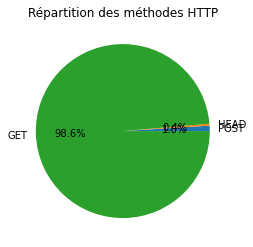

In [0]:
httpMethods = sqlContext.sql("SELECT method, COUNT(*) AS count FROM logs GROUP BY method")
httpMethods_rdd = httpMethods.rdd.map(lambda row: (row[0], row[1]))

httpMethods_df = sqlContext.createDataFrame(httpMethods_rdd, ["method", "count"])

# Affichage du DataFrame
display(httpMethods_df)

# Conversion du DataFrame en Pandas DataFrame
httpMethods_pandas = httpMethods_df.toPandas()


plt.pie(httpMethods_pandas['count'], labels=httpMethods_pandas['method'], autopct='%1.1f%%')
plt.title('Répartition des méthodes HTTP')
plt.show()



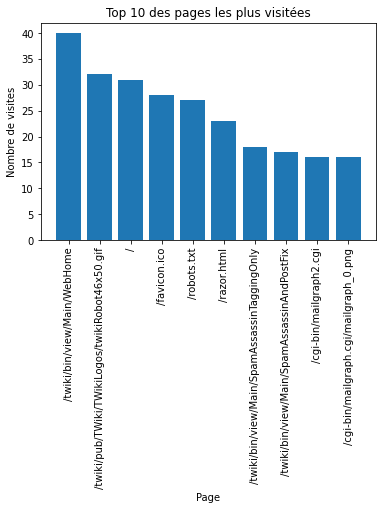

In [0]:
#les pages les plus visitées
topVisitedPages = sqlContext.sql("SELECT endpoint, COUNT(*) AS count FROM logs GROUP BY endpoint ORDER BY count DESC LIMIT 10")

# Conversion du résultat en Pandas DataFrame
topVisitedPages_df = topVisitedPages.toPandas()

plt.bar(topVisitedPages_df['endpoint'], topVisitedPages_df['count'])
plt.xlabel('Page')
plt.ylabel('Nombre de visites')
plt.title('Top 10 des pages les plus visitées')
plt.xticks(rotation='vertical')
plt.show()


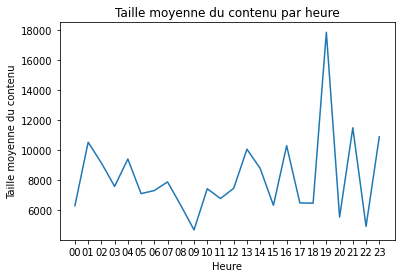

In [0]:
# la taille moyenne du contenu par heure
contentSizePerHour = sqlContext.sql("SELECT SUBSTRING(time, 1, 2) AS hour, AVG(content_size) AS avg_size FROM logs GROUP BY hour ORDER BY hour")

# Conversion du résultat en Pandas DataFrame
contentSizePerHour_df = contentSizePerHour.toPandas()

# Création du graphique en ligne
plt.plot(contentSizePerHour_df['hour'], contentSizePerHour_df['avg_size'])
plt.xlabel('Heure')
plt.ylabel('Taille moyenne du contenu')
plt.title('Taille moyenne du contenu par heure')
plt.show()
